# 5.2 LLM_policy_enforcer

## Load Dataset

In [ ]:
from google.colab import drive
import os
import pandas as pd
import json
from openai import OpenAI
from tqdm import tqdm

drive.mount('/content/drive', force_remount=True)

# Define paths
project_dir = '/content/drive/MyDrive/4awesome/'
data_dir = os.path.join(project_dir, 'Data')

# Load data
reviews_file = os.path.join(data_dir, 'reviews_with_features.csv')
reviews = pd.read_csv(reviews_file)

print("Columns in CSV:", reviews.columns)
print("First few rows:")
reviews.head()

Mounted at /content/drive
Columns in CSV: Index(['business_name', 'text', 'rating', 'rating_category', 'cleaned_text',
       'text_length', 'cleaned_text_length', 'promotional_score',
       'sentiment_polarity', 'sentiment_subjectivity', 'char_count',
       'avg_word_len', 'unique_word_ratio', 'vader_pos', 'vader_neg',
       'vader_neu', 'vader_compound'],
      dtype='object')
First few rows:


,business_name,text,rating,rating_category,cleaned_text,text_length,cleaned_text_length,promotional_score,sentiment_polarity,sentiment_subjectivity,char_count,avg_word_len,unique_word_ratio,vader_pos,vader_neg,vader_neu,vader_compound
0,Haci'nin Yeri - Yigit Lokantasi,We went to Marmaris with my wife for a holiday...,5,taste,went marmaris wife holiday. chose restaurant p...,130,61,1,0.026190,0.700000,395,6.370968,0.887097,0.059,0.042,0.899,0.3071
1,Haci'nin Yeri - Yigit Lokantasi,During my holiday in Marmaris we ate here to f...,4,menu,holiday marmaris ate fit food. really good foo...,179,83,1,0.164583,0.660417,527,6.273810,0.857143,0.102,0.050,0.847,0.7565
2,Haci'nin Yeri - Yigit Lokantasi,Prices are very affordable. The menu in the ph...,3,outdoor_atmosphere,price affordable. menu photo cost 108 liras. w...,31,19,0,0.275000,0.700000,124,6.200000,0.950000,0.227,0.070,0.703,0.7184
3,Haci'nin Yeri - Yigit Lokantasi,Turkey's cheapest artisan restaurant and its f...,5,indoor_atmosphere,turkey's cheapest artisan restaurant food deli...,9,6,0,1.000000,1.000000,52,7.428571,0.857143,0.333,0.000,0.667,0.6114
4,Haci'nin Yeri - Yigit Lokantasi,I don't know what you will look for in terms o...,3,menu,know look term price performance point; taste;...,31,15,0,0.000000,0.100000,97,6.062500,0.937500,0.000,0.000,1.000,0.0000


## Set up OpenAI client

In [ ]:
import os
os.environ["OPENAI_API_KEY"] = "INSERT_OPENAI_API_KEY"

client = OpenAI(api_key=os.environ["OPENAI_API_KEY"])

## One-shot classification prompt function

### 🧠 Referencing SHAP Insights for LLM Prompt Design

The SHAP summary plot in step 5.1 was used to identify which words were most influential in the aspect classification task for restaurant reviews. Words such as "delicious", "taste", "staff", "expensive", "breakfast", and "service" appeared frequently as strong indicators of food-related or dining-related content.

These keywords directly informed the LLM prompting strategy for relevancy checking. In the LLM prompt, I specifically instructed the model to treat a review as relevant to a restaurant if it discusses words like those

By grounding the prompt in actual model-extracted feature importance (via SHAP), I ensured that the relevancy classification used language features that were already learned and validated by the logistic regression model, hence making the LLM output more robust.


In [ ]:
def classify_review_llm(review_text):
    """
    Classifies the review into:
    - is_ad: True/False
    - did_not_visit: True/False
    - relevant_to_restaurant: One of ['Very relevant', 'Slightly relevant', 'Slightly irrelevant', 'Very irrelevant']
    - evidence_snippets: 1–2 short snippets (max 10 words)
    """

    SYSTEM_PROMPT = (
        "You are a policy enforcement assistant for restaurant reviews.\n\n"
        "You must classify whether a review violates any of the following platform policies:\n"
        "1. Advertisement/Promotion: Mentions discount codes, social handles, URLs, referral promotions, or encourages clicks/follows.\n"
        "2. Did Not Visit: Reviewer admits or implies they didn’t go to the place (e.g., 'never been', 'my friend said').\n"
        "3. Irrelevant Content: The content is off-topic (e.g., delivery services, weather, sports scores, tech support, etc.).\n"
        "If none apply and the review is about the restaurant experience (e.g., food, taste, price, service, breakfast, lunch, dinner), it's considered relevant.\n\n"
        "Do NOT classify as AD just because the review says things like 'highly recommend', 'come here', or 'must try' — that can be genuine praise.\n\n"
        "For each review:\n"
        "- Return the following keys:\n"
        "    - is_ad: true or false\n"
        "    - did_not_visit: true or false\n"
        "    - relevant_to_restaurant: One of 'Very relevant', 'Slightly relevant', 'Slightly irrelevant', 'Very irrelevant'\n"
        "    - evidence_snippets: 1–2 short snippets (max 10 words each) that support the decision\n\n"
        "Examples:\n"
        "Review: 'Click this link for the best deals! http://spam.com'\n"
        "→ is_ad: true, did_not_visit: false, relevant_to_restaurant: 'Very irrelevant', evidence_snippets: ['Click this link', 'http://spam.com']\n\n"
        "Review: 'Never been there, but I think it's overrated.'\n"
        "→ is_ad: false, did_not_visit: true, relevant_to_restaurant: 'Very irrelevant', evidence_snippets: ['Never been there']\n\n"
        "Review: 'The grilled lamb was juicy, but service was slow.'\n"
        "→ is_ad: false, did_not_visit: false, relevant_to_restaurant: 'Very relevant', evidence_snippets: ['grilled lamb was juicy', 'service was slow']\n"
    )

    prompt = f"{SYSTEM_PROMPT}\nNow classify this review:\n\"{review_text}\"\n\nReturn a JSON object with the exact keys: is_ad, did_not_visit, relevant_to_restaurant, evidence_snippets."

    try:
        response = client.chat.completions.create(
            model="gpt-4o-mini",
            messages=[{"role": "user", "content": prompt}],
            temperature=0.2
        )
        llm_output = response.choices[0].message.content.strip()
        result_json = json.loads(llm_output)

        # Normalize keys just in case
        return {
            "is_ad": result_json.get("is_ad", False),
            "did_not_visit": result_json.get("did_not_visit", False),
            "relevant_to_restaurant": result_json.get("relevant_to_restaurant", "Slightly irrelevant"),
            "evidence_snippets": result_json.get("evidence_snippets", [])
        }

    except Exception as e:
        return {
            "error": str(e),
            "raw_output": llm_output if 'llm_output' in locals() else None
        }

In [ ]:
# Test pool of example reviews
test_pool = [
    "Subscribe my channel for travel tips! Use code SAVE10.",
    "Never been there, but my friend said it's terrible.",
    "The weather in Datça was sunny; we walked along the beach all day.",
    "Click this link to win an iPhone: http://spam.example.com",
    "Package lost at the post office; very disappointed with logistics.",
    "Great museum exhibition downtown, nothing about food though.",
    "Go to @bestfooddeals for coupons!!!",
    "Match was 2-1, our team won! Best night ever!",
    "Looking for roommates near campus; DM me.",
    "Printer ink exploded; tech support useless.",
    "Food was very good, i will come again!"
]

# Run LLM classifier on test pool
test_results = []

for review in tqdm(test_pool, desc="Testing test_pool"):
    result = classify_review_llm(review)
    test_results.append(result)

# Convert to DataFrame for easy inspection
import pandas as pd
pd.DataFrame(test_results)


Testing test_pool: 100%|██████████| 11/11 [00:13<00:00,  1.22s/it]


,is_ad,did_not_visit,relevant_to_restaurant,evidence_snippets
0,True,False,Very irrelevant,"[Subscribe my channel, Use code SAVE10]"
1,False,True,Very irrelevant,"[Never been there, my friend said it's terrible]"
2,False,False,Very irrelevant,"[weather in Datça, walked along the beach]"
3,True,False,Very irrelevant,"[Click this link, http://spam.example.com]"
4,False,False,Very irrelevant,"[lost at the post office, disappointed with lo..."
5,False,False,Very irrelevant,[nothing about food]
6,True,False,Very irrelevant,"[@bestfooddeals, coupons]"
7,False,False,Very irrelevant,"[Match was 2-1, Best night ever]"
8,True,False,Very irrelevant,"[Looking for roommates, DM me]"
9,False,False,Very irrelevant,"[Printer ink exploded, tech support useless]"


## Apply LLM classification to each review

In [ ]:
from tqdm import tqdm

results = []

for idx, row in tqdm(reviews.iterrows(), total=reviews.shape[0], desc="Classifying reviews"):
    review_text = row['text']
    result = classify_review_llm(review_text)
    results.append(result)


Classifying reviews: 100%|██████████| 1067/1067 [22:00<00:00,  1.24s/it]


## Combine results with original DataFrame

In [ ]:
results_df = pd.DataFrame(results)
reviews_with_llm = pd.concat([reviews.reset_index(drop=True), results_df], axis=1)
reviews_with_llm.head()

,business_name,text,rating,rating_category,cleaned_text,text_length,cleaned_text_length,promotional_score,sentiment_polarity,sentiment_subjectivity,char_count,avg_word_len,unique_word_ratio,vader_pos,vader_neg,vader_neu,vader_compound,is_ad,did_not_visit,relevant_to_restaurant,evidence_snippets,error,raw_output
0,Haci'nin Yeri - Yigit Lokantasi,We went to Marmaris with my wife for a holiday...,5,taste,went marmaris wife holiday. chose restaurant p...,130,61,1,0.026190,0.700000,395,6.370968,0.887097,0.059,0.042,0.899,0.3071,False,False,Very relevant,"[juicy food, food prices were unbelievably cheap]",NaN,NaN
1,Haci'nin Yeri - Yigit Lokantasi,During my holiday in Marmaris we ate here to f...,4,menu,holiday marmaris ate fit food. really good foo...,179,83,1,0.164583,0.660417,527,6.273810,0.857143,0.102,0.050,0.847,0.7565,False,False,Very relevant,"[food is cheap and nice, food variety]",NaN,NaN
2,Haci'nin Yeri - Yigit Lokantasi,Prices are very affordable. The menu in the ph...,3,outdoor_atmosphere,price affordable. menu photo cost 108 liras. w...,31,19,0,0.275000,0.700000,124,6.200000,0.950000,0.227,0.070,0.703,0.7184,False,False,Very relevant,"[Prices are very affordable, Boiled meat was d...",NaN,NaN
3,Haci'nin Yeri - Yigit Lokantasi,Turkey's cheapest artisan restaurant and its f...,5,indoor_atmosphere,turkey's cheapest artisan restaurant food deli...,9,6,0,1.000000,1.000000,52,7.428571,0.857143,0.333,0.000,0.667,0.6114,False,False,Very relevant,"[cheapest artisan restaurant, food is delicious]",NaN,NaN
4,Haci'nin Yeri - Yigit Lokantasi,I don't know what you will look for in terms o...,3,menu,know look term price performance point; taste;...,31,15,0,0.000000,0.100000,97,6.062500,0.937500,0.000,0.000,1.000,0.0000,False,False,Slightly relevant,"[price performance point, big plus for those w...",NaN,NaN


## Do data exploration on final CSV


In [ ]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
reviews_with_llm[reviews_with_llm['is_ad'] == True]  #wrongly flagged just because it has . and / inside the review

,business_name,text,rating,rating_category,cleaned_text,text_length,cleaned_text_length,promotional_score,sentiment_polarity,sentiment_subjectivity,char_count,avg_word_len,unique_word_ratio,vader_pos,vader_neg,vader_neu,vader_compound,is_ad,did_not_visit,relevant_to_restaurant,evidence_snippets,error,raw_output
468,Zula,Well prepared hamburger; special taste. But a little bit expensive.here/,5,outdoor_atmosphere,well prepared hamburger; special taste. little bit expensive.here/,10,8,1,0.084821,0.535714,66,7.333333,0.888889,0.447,0.0,0.553,0.431,True,False,Very relevant,"[a little bit expensive, special taste]",NaN,NaN


In [ ]:
reviews_with_llm[reviews_with_llm['did_not_visit'] == True]

,business_name,text,rating,rating_category,cleaned_text,text_length,cleaned_text_length,promotional_score,sentiment_polarity,sentiment_subjectivity,char_count,avg_word_len,unique_word_ratio,vader_pos,vader_neg,vader_neu,vader_compound,is_ad,did_not_visit,relevant_to_restaurant,evidence_snippets,error,raw_output
207,Vefa Bozacisi,Boza's are beautiful. The ones on sale are also freshly filled and prepared. It looks clean; but I don't know the exact details.,5,menu,boza's beautiful. one sale also freshly filled prepared. look clean; know exact details.,23,13,1,0.466667,0.712500,88,6.285714,0.928571,0.232,0.00,0.768,0.5789,False,True,Slightly irrelevant,[I don't know the exact details],NaN,NaN
214,Vefa Bozacisi,It is a flavor that can be tried when you go to Istanbul.,4,taste,flavor tried go istanbul.,13,4,0,0.000000,0.000000,25,5.000000,0.800000,0.000,0.00,1.000,0.0000,False,True,Slightly irrelevant,"[can be tried, when you go to Istanbul]",NaN,NaN
511,Ahsap Iskender,It was delicious as I heard.,5,outdoor_atmosphere,delicious heard.,6,2,0,1.000000,1.000000,16,5.333333,0.666667,0.481,0.00,0.519,0.5719,False,True,Slightly irrelevant,[as I heard],NaN,NaN
816,Salih Usta,My and my 3.5-year-old daughter's favorite place is in Samsun; we love the products of this place the most.,5,taste,3.5-year-old daughter's favorite place samsun; love product place most.,19,9,0,0.500000,0.700000,71,7.100000,0.800000,0.298,0.00,0.702,0.8020,False,True,Slightly irrelevant,"[favorite place is in Samsun, love the products]",NaN,NaN
819,Salih Usta,You won't regret that the products taste very good; but I've never seen such a bad staff before; definitely don't sit down and drink tea and coffee; take the product and leave; that's the most logical thing.,2,indoor_atmosphere,regret product taste good; never seen bad staff before; definitely sit drink tea coffee; take product leave; that's logical thing.,37,20,0,0.114921,0.497937,130,6.190476,0.904762,0.256,0.03,0.714,0.8686,False,True,Slightly relevant,"[never seen such a bad staff, take the product and leave]",NaN,NaN
851,Classic Thai,The waiters took care of me. That's why I left the restaurant before I could order.,1,indoor_atmosphere,waiter took care me. that's left restaurant could order.,16,9,1,0.000000,0.000000,56,5.600000,0.900000,0.198,0.00,0.802,0.4939,False,True,Very irrelevant,"[left the restaurant, before I could order]",NaN,NaN


In [ ]:
reviews_with_llm[reviews_with_llm['relevant_to_restaurant'] == "Very irrelevant"]

,business_name,text,rating,rating_category,cleaned_text,text_length,cleaned_text_length,promotional_score,sentiment_polarity,sentiment_subjectivity,char_count,avg_word_len,unique_word_ratio,vader_pos,vader_neg,vader_neu,vader_compound,is_ad,did_not_visit,relevant_to_restaurant,evidence_snippets,error,raw_output
851,Classic Thai,The waiters took care of me. That's why I left the restaurant before I could order.,1,indoor_atmosphere,waiter took care me. that's left restaurant could order.,16,9,1,0.0,0.0,56,5.6,0.9,0.198,0.0,0.802,0.4939,False,True,Very irrelevant,"[left the restaurant, before I could order]",NaN,NaN


### Merge with filtered final Dataframe

In [100]:
# --- Fix the wrongly flagged ad in LLM results ---
reviews_with_llm.loc[reviews_with_llm['is_ad'] == True, 'is_ad'] = False

# --- Load policy flags CSV ---
reviews_with_policy_flags = os.path.join(data_dir, 'reviews_with_policy_flags.csv')
reviews_with_policy_flags = pd.read_csv(reviews_with_policy_flags)

# --- Merge on business_name + text ---
combined_df = reviews_with_policy_flags.merge(
    reviews_with_llm,
    on=["business_name", "text", "rating", "cleaned_text", "text_length", "cleaned_text_length", "promotional_score", "sentiment_polarity", "sentiment_subjectivity", "char_count", \
        "avg_word_len", "unique_word_ratio", "vader_pos", "vader_neg", "vader_neu", "vader_compound",  "rating_category", "sentiment_subjectivity", "char_count", "avg_word_len", \
        "unique_word_ratio", "vader_pos", "vader_neg", "vader_neu", "vader_compound"],
    how="left"
)

columns_to_drop = ["error", "raw_output"]
combined_df = combined_df.drop(columns=columns_to_drop)

combined_df.head()


,business_name,text,rating,rating_category,cleaned_text,text_length,cleaned_text_length,promotional_score,sentiment_polarity,sentiment_subjectivity,char_count,avg_word_len,unique_word_ratio,vader_pos,vader_neg,vader_neu,vader_compound,rating_category_encoded,policy_ads,policy_short,policy_mismatch,is_ad,did_not_visit,relevant_to_restaurant,evidence_snippets
0,Haci'nin Yeri - Yigit Lokantasi,We went to Marmaris with my wife for a holiday. We chose this restaurant as a place for dinner based on the reviews and because we wanted juicy food. When we first went there was a serious queue. You proceed by taking the food you want in the form of an open buffet. Both vegetable dishes and meat dishes were plentiful. There was also dessert for those who wanted it. After you get what you want you pay at the cashier. They don't go through cards they work in cash. There was a lot of food variety. And the food prices were unbelievably cheap. We paid only 84 TL for all the meals here. It included buttermilk and bread. But unfortunately I can't say it's too clean as a place..,5,taste,went marmaris wife holiday. chose restaurant place dinner based review wanted juicy food. first went serious queue. proceed taking food want form open buffet. vegetable dish meat dish plentiful. also dessert wanted it. get want pay cashier. go card work cash. lot food variety. food price unbelievably cheap. paid 84 tl meal here. included buttermilk bread. unfortunately can't say clean place..,130,61,1,0.026190,0.700000,395,6.370968,0.887097,0.059,0.042,0.899,0.3071,3,True,False,False,False,False,Very relevant,"[juicy food, food prices were unbelievably cheap]"
1,Haci'nin Yeri - Yigit Lokantasi,During my holiday in Marmaris we ate here to fit the food. It's really good that the food is cheap and nice. Eating as much bread as you want is a big plus for those who are not satisfied without bread. It is a place that I can recommend to those who will go to Marmaris. On July 1 there was a small increase but even the price hike is cheap. I leave the photo of the latest prices and breakfast below. there was a serious queue. You proceed by taking the food you want in the form of an open buffet. Both vegetable dishes and meat dishes were plentiful. There was also dessert for those who wanted it. After you get what you want you pay at the cashier. They don't go through cards they work in cash. There was a lot of food variety. And the food prices were unbelievably cheap. We paid only 84 TL for all the meals here. It included buttermilk and bread. But unfortunately I can't say it's too clean as a place..,4,menu,holiday marmaris ate fit food. really good food cheap nice. eating much bread want big plus satisfied without bread. place recommend go marmaris. july 1 small increase even price hike cheap. leave photo latest price breakfast below. serious queue. proceed taking food want form open buffet. vegetable dish meat dish plentiful. also dessert wanted it. get want pay cashier. go card work cash. lot food variety. food price unbelievably cheap. paid 84 tl meal here. included buttermilk bread. unfortunately can't say clean place..,179,83,1,0.164583,0.660417,527,6.273810,0.857143,0.102,0.050,0.847,0.7565,1,True,False,False,False,False,Very relevant,"[food is cheap and nice, food variety]"
2,Haci'nin Yeri - Yigit Lokantasi,Prices are very affordable. The menu in the photo cost 108 liras. You have to wait 10-15 minutes for food. Staff is annoying. Well it tastes good. Boiled meat was delicious.,3,outdoor_atmosphere,price affordable. menu photo cost 108 liras. wait 10-15 minute food. staff annoying. well taste good. boiled meat delicious.,31,19,0,0.275000,0.700000,124,6.200000,0.950000,0.227,0.070,0.703,0.7184,2,False,False,False,False,False,Very relevant,"[Prices are very affordable, Boiled meat was delicious]"
3,Haci'nin Yeri - Yigit Lokantasi,Turkey's cheapest artisan restaurant and its food is delicious!,5,indoor_atmosphere,turkey's cheapest artisan restaurant food delicious!,9,6,

### Check for null values which may be outptted from the LLM

In [101]:
# Check which columns contain NaN
rows_with_nan = combined_df[combined_df.isna().any(axis=1)]
rows_with_nan

,business_name,text,rating,rating_category,cleaned_text,text_length,cleaned_text_length,promotional_score,sentiment_polarity,sentiment_subjectivity,char_count,avg_word_len,unique_word_ratio,vader_pos,vader_neg,vader_neu,vader_compound,rating_category_encoded,policy_ads,policy_short,policy_mismatch,is_ad,did_not_visit,relevant_to_restaurant,evidence_snippets
287,Nazar Cafe,Recommend.,4,indoor_atmosphere,recommend.,1,1,0,0.0,0.0,10,5.0,0.5,1.0,0.0,0.0,0.3612,0,False,True,False,NaN,NaN,NaN,NaN


### policy_irrelevant and policy_novisit

In [102]:
# if they contain NaN, means prompt is too short to be evaluated, so we should just put True for all
combined_df['did_not_visit'] = combined_df['did_not_visit'].fillna(True)
combined_df['is_ad'] = combined_df['is_ad'].fillna(True)
combined_df['relevant_to_restaurant'] = combined_df['relevant_to_restaurant'].fillna('Very irrelevant')

combined_df['policy_irrelevant'] = combined_df['relevant_to_restaurant'] == 'Very irrelevant'
combined_df.rename({'did_not_visit': 'policy_novisit'}, axis=1, inplace=True)

# we use policy_ads from llm output instead
combined_df = combined_df.drop(columns=["policy_ads"])
combined_df.rename({'is_ad': 'policy_ads'}, axis=1, inplace=True)

/tmp/ipython-input-1006059908.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  combined_df['did_not_visit'] = combined_df['did_not_visit'].fillna(True)
/tmp/ipython-input-1006059908.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  combined_df['is_ad'] = combined_df['is_ad'].fillna(True)


In [104]:
combined_df.head(1)

,business_name,text,rating,rating_category,cleaned_text,text_length,cleaned_text_length,promotional_score,sentiment_polarity,sentiment_subjectivity,char_count,avg_word_len,unique_word_ratio,vader_pos,vader_neg,vader_neu,vader_compound,rating_category_encoded,policy_short,policy_mismatch,policy_ads,policy_novisit,relevant_to_restaurant,evidence_snippets,policy_irrelevant
0,Haci'nin Yeri - Yigit Lokantasi,We went to Marmaris with my wife for a holiday. We chose this restaurant as a place for dinner based on the reviews and because we wanted juicy food. When we first went there was a serious queue. You proceed by taking the food you want in the form of an open buffet. Both vegetable dishes and meat dishes were plentiful. There was also dessert for those who wanted it. After you get what you want you pay at the cashier. They don't go through cards they work in cash. There was a lot of food variety. And the food prices were unbelievably cheap. We paid only 84 TL for all the meals here. It included buttermilk and bread. But unfortunately I can't say it's too clean as a place..,5,taste,went marmaris wife holiday. chose restaurant place dinner based review wanted juicy food. first went serious queue. proceed taking food want form open buffet. vegetable dish meat dish plentiful. also dessert wanted it. get want pay cashier. go card work cash. lot food variety. food price unbelievably cheap. paid 84 tl meal here. included buttermilk bread. unfortunately can't say clean place..,130,61,1,0.02619,0.7,395,6.370968,0.887097,0.059,0.042,0.899,0.3071,3,False,False,False,False,Very relevant,"[juicy food, food prices were unbelievably cheap]",False


### policy violation percentage

In [105]:
policy_cols = ['policy_ads', 'policy_short', 'policy_mismatch', 'policy_novisit', 'policy_irrelevant']

# Convert to integers (True → 1, False → 0), sum per row, and divide by total number of policies
combined_df['policy_violation_percentage'] = combined_df[policy_cols].astype(int).sum(axis=1) / len(policy_cols)

### Export final combined csv

In [ ]:
# Preview
pd.reset_option('display.max_colwidth')
combined_df.head(1)

,business_name,text,rating,rating_category,cleaned_text,text_length,cleaned_text_length,promotional_score,sentiment_polarity,sentiment_subjectivity,char_count,avg_word_len,unique_word_ratio,vader_pos,vader_neg,vader_neu,vader_compound,rating_category_encoded,policy_ads,policy_short,policy_mismatch,policy_novisit,relevant_to_restaurant,evidence_snippets,policy_irrelevant,policy_violation_percentage
0,Haci'nin Yeri - Yigit Lokantasi,We went to Marmaris with my wife for a holiday...,5,taste,went marmaris wife holiday. chose restaurant p...,130,61,1,0.02619,0.7,395,6.370968,0.887097,0.059,0.042,0.899,0.3071,3,True,False,False,False,Very relevant,"[juicy food, food prices were unbelievably cheap]",False,0.2


policy_violation_percentage (Evaluation)

In [115]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set seaborn style
sns.set(style="whitegrid")

# Count occurrences of each unique policy_violation_percentage
violation_counts = combined_df['policy_violation_percentage'].value_counts().sort_index()

# Convert counts to percentages
violation_percentages = (violation_counts / len(combined_df) * 100).round(2)

# Display as a table
violation_table = pd.DataFrame({
    'Policy Violation Percentage': violation_percentages.index,
    'Count': violation_counts.values,
    'Percentage of Reviews (%)': violation_percentages.values
})

violation_table

,Policy Violation Percentage,Count,Percentage of Reviews (%)
0,0.0,821,76.94
1,0.2,229,21.46
2,0.4,15,1.41
3,0.6,1,0.09
4,0.8,1,0.09


/tmp/ipython-input-2194263622.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_violation.index, y=avg_violation.values, palette='light:#5A9_r')


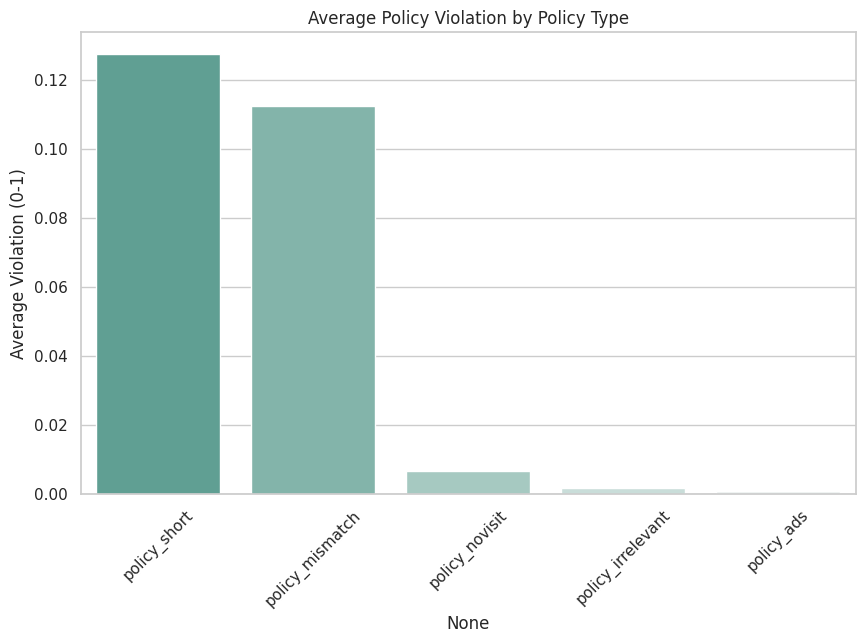

In [114]:
#Bar plot of average violation by policy
avg_violation = combined_df[policy_cols].mean().sort_values(ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x=avg_violation.index, y=avg_violation.values, palette='light:#5A9_r')
plt.title('Average Policy Violation by Policy Type')
plt.ylabel('Average Violation (0-1)')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# --- Save final result ---
combined_df.to_csv("/content/drive/MyDrive/4awesome/Data/reviews_final.csv", index=False)